### Todo

We could add Outlier removal to preprocessing

#### This cell is for defining various OPTIONS used for this notebook (working directory, how many rows and columns pandas displays for a dataframe, etc). 

#### Preferably this cell is also where we do important imports (for example pandas and numpy)

In [1]:
import os 
#Input the directory where your joined_data.csv is located 
#os.chdir('C:/Users/Trond/Documents/Master 2020/Processed data')
os.chdir('C:/Users/Briggstone/Documents/Master 2020/Processed data')
# os.chdir('C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data')

#Where you want the csv file of the merged data to be placed
output_filepath = 'C:/Users/Briggstone/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/Trond/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data'

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split

# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)


# Joined imputed data to import, 0 = MODE/MEAN IMPUTATION, 1 = SIMILARITY MEASURE
MV_FLAG = 0

#The portion of data in the test set
TEST_PORTION = 0.2

#### In this cell we import our joined imputed data based on MV_FLAG

In [2]:
if MV_FLAG == 0:
    data = pd.read_csv('joined_data_mm.csv') # missing values filled with mean/median
else: 
    data = pd.read_csv('joined_data_heom.csv') # missing values filled based on HEOM measure



#### In this cell we define the functions we need to calculate derived values from various variables

In [3]:
#Functions for calculating derived values for various data tables

def mcatot (df):
    ''' Montreal cognitive test
    sum variables and 1 point to score if education years <= 12 and score < 30
    '''
    
    component_vars = ["MCAALTTM", "MCACUBE", "MCACLCKC", "MCACLCKN", "MCACLCKH", "MCALION", "MCARHINO", "MCACAMEL", \
    "MCAFDS", "MCABDS", "MCAVIGIL", "MCASER7", "MCASNTNC", "MCAVF", "MCAABSTR", "MCAREC1", "MCAREC2", "MCAREC3", "MCAREC4", \
    "MCAREC5", "MCADATE", "MCAMONTH", "MCAYR", "MCADAY", "MCAPLACE", "MCACITY"]
    
    df['MCATOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)
    
    df['MCATOT'] = df.apply(lambda row_wise: row_wise["MCATOT"] + 1 if row_wise["EDUCYRS"] <= 12 and row_wise["MCATOT"] < 30 else row_wise["MCATOT"] , axis=1)   
    

def vlttot (df):
    ''' Semantic Fluency
    VLTANIM, VLTVEG,VLTFRUIT need to be summed in order to obtain a final score'''
    
    component_vars = ["VLTANIM", "VLTVEG", "VLTFRUIT"]
    
    df['VLTTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def remqtot (df):
    '''REM sleep behavior disorder (RBD)'''
    
    component_vars = ["STROKE","HETRA", "PARKISM", "RLS", "NARCLPSY", "DEPRS", "EPILEPSY", "BRNINFM", "CNSOTH"]
        
    score = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    
    # 1 point if any of these component variables had a 1, else 0
    score = pd.Series(np.where(score >= 1, 1, 0))
    
    df.drop(component_vars, inplace = True, axis = 1)

    component_vars = ["DRMVIVID", "DRMAGRAC", "DRMNOCTB", "SLPLMBMV", "SLPINJUR", \
                      "DRMVERBL", "DRMFIGHT", "DRMUMV", "DRMOBJFL", "MVAWAKEN", "DRMREMEM", "SLPDSTRB"]
    
    score += df.loc[:, component_vars].sum(axis = 1, skipna = False)

    df['REMTOT'] = score
    df.drop(component_vars, inplace = True, axis = 1)

    
def gdsstot (df):
    '''Geriatric Depression Scale'''
    
    component_vars = ["GDSSATIS", "GDSDROPD", \
    "GDSEMPTY", "GDSBORED", "GDSGSPIR", "GDSAFRAD", "GDSHAPPY", "GDSHLPLS", "GDSHOME", "GDSMEMRY", "GDSALIVE", "GDSWRTLS", "GDSENRGY", \
    "GDSHOPLS", "GDSBETER"]
    
    df['GDSSTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def sidttot (df):
    '''Olfactory impairment: University of Pennsylvania Smell ID Test'''
    component_vars = ["UPSITBK1", "UPSITBK2", "UPSITBK3", "UPSITBK4"]
    
    df['SIDTTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def epsstot (df):
    '''Epworth Sleepiness Scale'''
    
    component_vars = ["ESS1", "ESS2", \
    "ESS3", "ESS4", "ESS5", "ESS6", "ESS7", "ESS8"]
    
    df['EPSSTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def scoptot(df):
    '''Scales for Outcomes in Parkinson’s Disease–Autonomic'''

    component_vars = ["SCAU1", "SCAU2", \
    "SCAU3", "SCAU4", "SCAU5", "SCAU6", "SCAU7", "SCAU8", "SCAU9", "SCAU10", "SCAU11", "SCAU12", "SCAU13", \
    "SCAU14", "SCAU15", "SCAU16", "SCAU17", "SCAU18", "SCAU19", "SCAU20", "SCAU21", "SCAU22", "SCAU23", "SCAU24", "SCAU25"]
    
    df['SCOPTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)
    

def msu3tot(df):
    '''Movement Disorders Society–Unified Parkinson Disease Rating Scale'''
    
    component_vars = ['NP3BRADY', 'NP3FACXP', 'NP3FRZGT', \
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML', 'NP3KTRMR', 'NP3LGAGL', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR', \
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'PN3RIGRL', 'NP3RIGN', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU', \
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR', 'NP3LGAGR', 'NP3RIGLU']
       
    df['MSU3TOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    #df.drop(component_vars, inplace = True, axis = 1) #cannot drop, variables needed in tremor and pigd

    
def tremor(df):
    '''Tremor score'''
    
    component_vars = ["NP2TRMR", "NP3PTRMR", "NP3PTRML", "NP3KTRMR", "NP3KTRML", "NP3RTARU", "NP3RTALU", "NP3RTARL", "NP3RTALL", \
    "NP3RTALJ", "NP3RTCON"]
    
    df['TREMOR'] = df.loc[:, component_vars].mean(axis = 1, skipna = False)
    #df.drop(component_vars, inplace = True, axis = 1) #cannot drop, variables needed in tremor and pigd
    
    
def pigd(df):
    '''PIGD score'''
    
    component_vars = ["NP2WALK", "NP2FREZ", "NP3GAIT", "NP3FRZGT", "NP3PSTBL"]
    df['PIGD'] = df.loc[:, component_vars].mean(axis = 1, skipna = False)
    
    component_vars = ['NP3BRADY', 'NP3FACXP', 'NP3FRZGT', \
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML', 'NP3KTRMR', 'NP3LGAGL', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR', \
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'PN3RIGRL', 'NP3RIGN', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU', \
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR', "NP2TRMR", "NP2WALK", "NP2FREZ", 'NP3LGAGR', 'NP3RIGLU']
    #cannot drop before we discuss missing values
    df.drop(component_vars, inplace = True, axis = 1) #drop everything from msu3tot, tremor and pig
    

def td_pigd_ratio(df):
    '''Tremor/PIGD ratio'''
    
    component_vars = ['TREMOR', 'PIGD']
    df['TD_PIGD_RATIO'] = df.apply(lambda x: ratio(x['TREMOR'], x['PIGD']), axis=1)
    df.drop(component_vars, inplace = True, axis = 1)

    
def ratio(x, y):
    ''' Calculate TD/PGID ratio'''
    
    if y == 0:
        if x == 0:
            ratio = 0 #indeterminate
        else: 
            ratio =1 #TD
    elif x/y >= 1.15:
        ratio = 1 #TD
    elif x/y <= 0.9:
        ratio = 2 #PIGD
    else:
        ratio = 0 #indeterminate 
    return ratio

#### In this cell we define functions for encoding and dichotomizing variables

In [4]:
#Functions for encoding and dichotomizing variables

def famhist(df):
    '''Family history of Parkinson's Disease'''
    
    component_vars = ["BIOMOMPD", "BIODADPD", "FULSIBPD", "HAFSIBPD", "MAGPARPD", "PAGPARPD", "MATAUPD", "PATAUPD", "KIDSPD"]
        
    score = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    
    # if score >= 1 then 1, else 0
    # if score = NaN, then 0
    score = pd.Series(np.where(score >= 1, 1, 0))
    
    df.drop(component_vars, inplace = True, axis = 1)
    df['FAMHIST'] = score
    
    
def sleepy(df):
    '''Dichotomize EPSSTOT, Epworth Sleepiness Scale'''
    
    # if score < 10 subjects will be classified as 0 (not sleepy)
    # if score >= 10 subject will be classified as 1 (sleepy).
    df['SLEEPY'] = df['EPSSTOT'].apply(lambda x: np.where(x >=10, 1, 0))

    df.drop('EPSSTOT', inplace = True, axis = 1)


def depr(df):
    '''Dichotomize GDSSTOT, Geriatric Depression Scale'''
    
    # if score <5 subjects will be classified as 0 (non-depressed).
    # if score >= 5 subjects will be classified as 1 (depressed) 
    df['DEPR'] = df['GDSSTOT'].apply(lambda x: np.where(x >=5, 1, 0))

    df.drop('GDSSTOT', inplace = True, axis = 1)


def rbd(df):
    '''Dichotomize REMTOT, REM sleep behavior disorder (RBD)'''
       
    # if score <5 subjects will be classified as 0 (RBD negative).
    # if score >= 5 subjects will be classified as 1 (RBD positive) 
    df['RBD'] = df['REMTOT'].apply(lambda x: np.where(x >=5, 1, 0))

    df.drop('REMTOT', inplace = True, axis = 1)
    

def hall(df):
    '''Dihotomize NP1HALL dependent variable'''
    
    # if the patient has not suffered hallucinations, we consider it 0
    # if the patient has suffered >= 1 times hallucinations, we consider it 1   
    df['HALL'] = df['NP1HALL'].apply(lambda x: np.where(x >=1, 1, 0))

    df.drop('NP1HALL', inplace = True, axis = 1)


#### All preprocessing functions together

In [5]:
def preprocess(df):
    '''All preprocessing together'''
    mcatot(df)
    vlttot(df)
    remqtot(df)
    gdsstot(df)
    sidttot(df)
    epsstot(df)
    scoptot(df)
    msu3tot(df)
    tremor(df)
    pigd(df)
    td_pigd_ratio(df)
    famhist(df)
    sleepy(df)
    depr(df)
    rbd(df)
    hall(df)    

#### In this cell we apply our preprocessing functions on the data and inspect the final data table, including correlations between features

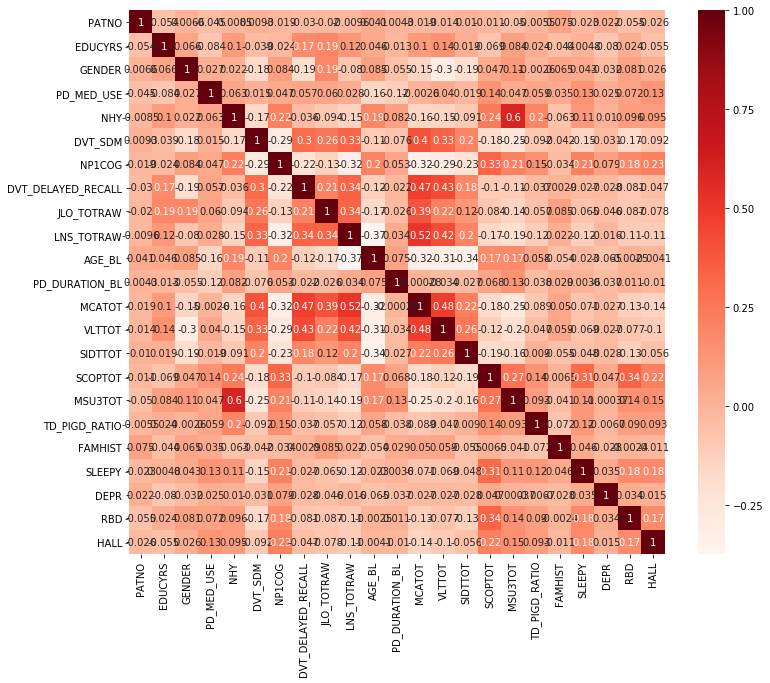

In [6]:
preprocess(data)

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### In this cell we seperate out data set into training and test sets and apply standardization to numeric columns

In [7]:
#We have to ensure that all longitudinal observations from one patient ends up in the same sample
tempdata = pd.DataFrame(data.PATNO.unique(), columns = ["PATNO"])

HALL_EVER = []
for id in data.PATNO.unique():

    if data.loc[(data.PATNO == id) & (data.HALL == 1), "HALL"].empty:
        HALL_EVER.append(0)
    else:
        HALL_EVER.append(1)

print("Number of patients which hallucinates eventually: ",  sum(HALL_EVER), " which is ", sum(HALL_EVER)/ len(HALL_EVER), " percent of patients" )
    
Y = HALL_EVER
X = tempdata


train, test, _, _ = train_test_split( X, Y, test_size= TEST_PORTION, random_state= 1, stratify= Y)

train = data.merge(train, how = "inner", on = "PATNO")
test = data.merge(test, how = "inner", on = "PATNO")

Number of patients which hallucinates eventually:  114  which is  0.26450116009280744  percent of patients


#### In this cell we apply standardization to numeric columns and output train and test to disk

In [8]:
def standardize_df (df, standardization):
    
    pd.set_option('mode.chained_assignment', None)
    columns = standardization.loc[:, "COLUMN_NAME"].values
    for i,c in enumerate(columns):
        df.loc[:,c] -= standardization.at[i,"MEAN"]
        df.loc[:,c] /= standardization.at[i,"STD"]
        
    pd.set_option('mode.chained_assignment', "warn")


column_types = pd.read_csv("Column_Data_Types_Final.csv")

numeric_columns = column_types.loc[column_types.DATA_TYPE == "Numeric", "COLUMN_NAME"].values

mean = np.mean(train.loc[:, numeric_columns])
std = np.std(train.loc[:, numeric_columns])

standardization = pd.DataFrame(numeric_columns, columns = ["COLUMN_NAME"])
standardization["MEAN"] = mean.values
standardization["STD"] = std.values

#Saving the standardization so we can later apply to test data
standardization.to_csv(output_filepath + '/standardization.csv', index = False)

standardize_df(train, standardization)

#Output train and test to disk

train.to_csv(output_filepath + '/train.csv', index = False)
test.to_csv(output_filepath + '/test.csv', index = False)




#### In this cell we explore the distribution of our response HALL over time

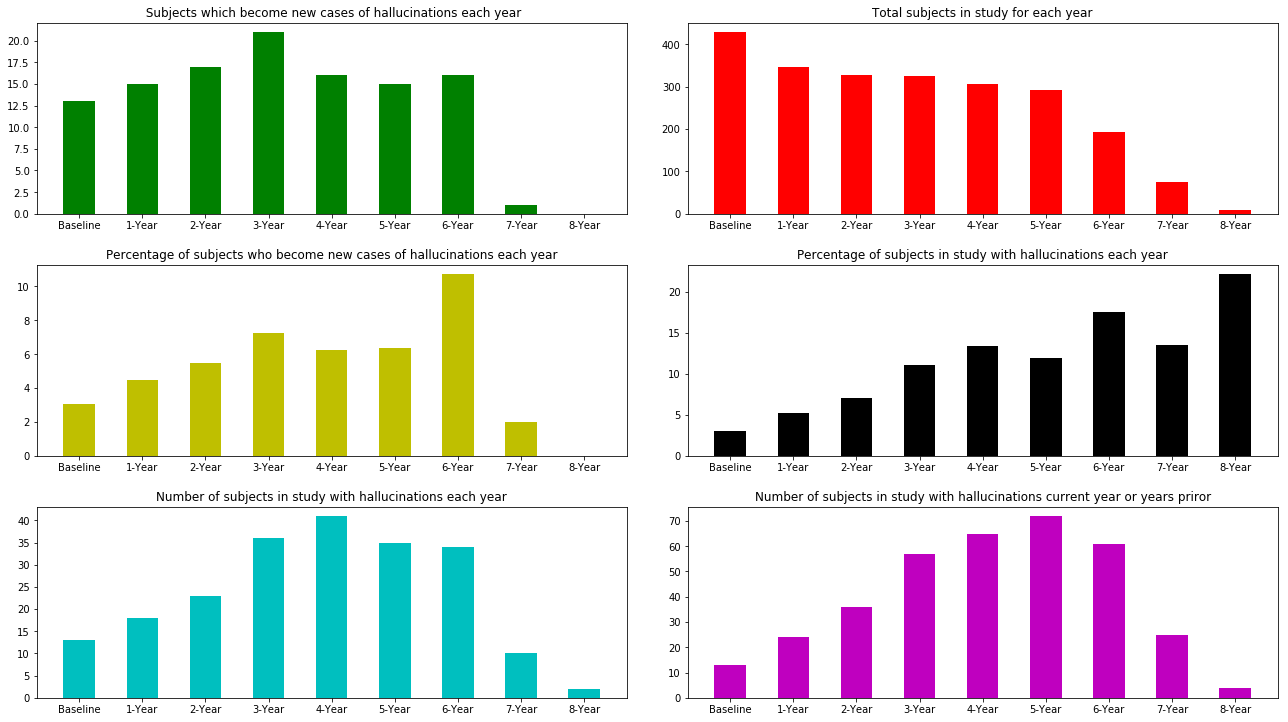

In [32]:
event_ids = data.loc[:,"EVENT_ID"].unique()
remove = np.array(["V03", "V05", "ST", "PW"])
event_ids = np.setdiff1d(event_ids, remove)

event_id_to_years = {
    "BL" : "Baseline",
    "V04": "1-Year",
    "V06": "2-Year",
    "V08": "3-Year",
    "V10": "4-Year",
    "V12": "5-Year",
    "V13": "6-Year",
    "V14": "7-Year",
    "V15": "8-Year"   
}

'''
distribution1 = new cases each year
distribution2 = total subjects in study each year
distribution3 = percentage of total subjects each year that become new caseses
distribution4 = The percentage of total subjects that have hallucinations each year
distribution5 = The number of total subjects that have hallucinatiosn each year
'''


distribution1 = {}
tempdata = data

for x in event_ids:
    subjects_hall = tempdata.loc[(tempdata.EVENT_ID == x) & (tempdata.HALL == 1), "PATNO"].values
    
    distribution1[event_id_to_years[x]] = subjects_hall.size
    
    for i in subjects_hall:
        tempdata = tempdata[tempdata.PATNO != i]
        


distribution2 = {}
tempdata = data

for x in event_ids:
    subjects_number = data.loc[data.EVENT_ID == x, "PATNO"].unique().size
    distribution2 [event_id_to_years[x]] = subjects_number
    

       
distribution3 = {}
tempdata = data

for x in event_ids:
    subjects_hall = tempdata.loc[(tempdata.EVENT_ID == x) & (tempdata.HALL == 1), "PATNO"].values
    distribution3[event_id_to_years[x]] = (subjects_hall.size / tempdata.loc[tempdata.EVENT_ID == x,"PATNO"].unique().size) * 100
    
    for i in subjects_hall:
        tempdata = tempdata[tempdata.PATNO != i]
        

distribution4 = {}
tempdata = data

for x in event_ids:
    subjects_hall = tempdata.loc[(tempdata.EVENT_ID == x) & (tempdata.HALL == 1), "PATNO"].values
    distribution4[event_id_to_years[x]] = (subjects_hall.size / tempdata.loc[tempdata.EVENT_ID == x,"PATNO"].unique().size) * 100
    
        




distribution5 = {}
tempdata = data

for x in event_ids:
    subjects_hall = tempdata.loc[(tempdata.EVENT_ID == x) & (tempdata.HALL == 1), "PATNO"].values
    distribution5[event_id_to_years[x]] = subjects_hall.size 
    

distribution6 = {}
tempdata = data
tempdata = tempdata[(tempdata.EVENT_ID != "ST") & (tempdata.EVENT_ID != "PW") & (tempdata.EVENT_ID != "V05") & (tempdata.EVENT_ID != "V03")]
unique_patno = tempdata.loc[:, "PATNO"].unique()

for x in unique_patno:
    subject_data = tempdata.loc[tempdata.PATNO == x, ["EVENT_ID", "HALL"]]
    subject_event_ids = np.sort(subject_data.EVENT_ID.unique())
    first_hall = 0
    for i in subject_event_ids:
        if first_hall != 1 and subject_data.loc[subject_data.EVENT_ID == i, ["HALL"]].values[0] == 1:
                first_hall = 1
        elif first_hall == 1:
                tempdata.loc[(tempdata.PATNO == x) & (tempdata.EVENT_ID == i), ["HALL"]] = 1
    

for x in event_ids:
    subjects_hall = tempdata.loc[(tempdata.EVENT_ID == x) & (tempdata.HALL == 1), "PATNO"].values
    distribution6[event_id_to_years[x]] = subjects_hall.size 

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad=3.0)


# distribution1 = new cases each year
axs[0,0].bar(distribution1.keys(), distribution1.values(), width=.5, color='g')
axs[0,0].title.set_text(" Subjects which become new cases of hallucinations each year")

#distribution2 = total subjects in study each year 
axs[0,1].bar(distribution2.keys(), distribution2.values(), width=.5, color='r')
axs[0,1].title.set_text("Total subjects in study for each year")

#distribution3 = percentage of total subjects each year that become new caseses
axs[1,0].bar(distribution3.keys(), distribution3.values(), width=.5, color='y')
axs[1,0].title.set_text("Percentage of subjects who become new cases of hallucinations each year")

#distribution4 = The percentage of total subjects that have hallucinations each year
axs[1,1].bar(distribution4.keys(), distribution4.values(), width=.5, color='k')
axs[1,1].title.set_text("Percentage of subjects in study with hallucinations each year")

#distribution5 = The number of total subjects that have hallucinatiosn each year
axs[2,0].bar(distribution5.keys(), distribution5.values(), width=.5, color='c')
axs[2,0].title.set_text("Number of subjects in study with hallucinations each year")

#distribution6 = The number of total subjects that have hallucinatiosn each year or years prior
axs[2,1].bar(distribution6.keys(), distribution6.values(), width=.5, color='m')
axs[2,1].title.set_text("Number of subjects in study with hallucinations current year or years priror")


In [30]:
tempdata = data[(data.EVENT_ID != "ST") & (data.EVENT_ID != "PW") & (data.EVENT_ID != "V05") & (data.EVENT_ID != "V03")]

unique_patno = tempdata.loc[:, "PATNO"].unique()

for x in unique_patno:
    subject_data = tempdata.loc[tempdata.PATNO == x, ["EVENT_ID", "HALL"]]
    subject_event_ids = np.sort(subject_data.EVENT_ID.unique())
    first_hall = 0
    for i in subject_event_ids:
        if first_hall == 0 and subject_data.loc[subject_data.EVENT_ID == i, ["HALL"]].values[0] == 1:
                first_hall = 1
        elif first_hall == 1:
                tempdata.loc[(tempdata.PATNO == x) & (tempdata.EVENT_ID == i), ["HALL"] ] = 1
            
tempdata.head()       


,PATNO,EDUCYRS,GENDER,EVENT_ID,PD_MED_USE,NHY,DVT_SDM,NP1COG,DVT_DELAYED_RECALL,JLO_TOTRAW,LNS_TOTRAW,AGE_BL,PD_DURATION_BL,MCATOT,VLTTOT,SIDTTOT,SCOPTOT,MSU3TOT,TD_PIGD_RATIO,FAMHIST,SLEEPY,DEPR,RBD,HALL
0,3400,18.0,0.0,BL,0,1.0,43.330002,0.0,54.0,13.0,10.0,39,0.75,24.0,63.0,30.0,12.0,18.0,2,0,1,1,1,0
1,3400,18.0,0.0,V04,3,2.0,41.669998,1.0,54.0,12.0,12.0,39,0.75,29.0,49.0,30.0,20.0,44.0,2,0,0,1,1,0
2,3400,18.0,0.0,V06,2,2.0,43.330002,1.0,44.0,12.0,10.0,39,0.75,30.0,53.0,30.0,22.0,29.0,0,0,0,1,0,0
3,3400,18.0,0.0,V12,4,2.0,32.000000,1.0,54.0,12.0,2.0,39,0.75,29.0,49.0,30.0,17.0,18.0,2,0,1,1,0,0
4,3400,18.0,0.0,V08,6,2.0,43.330002,2.0,54.0,12.0,12.0,39,0.75,30.0,59.0,30.0,25.0,33.0,2,0,1,1,1,0


In [25]:
data.head()

,PATNO,EDUCYRS,GENDER,EVENT_ID,PD_MED_USE,NHY,DVT_SDM,NP1COG,DVT_DELAYED_RECALL,JLO_TOTRAW,LNS_TOTRAW,AGE_BL,PD_DURATION_BL,MCATOT,VLTTOT,SIDTTOT,SCOPTOT,MSU3TOT,TD_PIGD_RATIO,FAMHIST,SLEEPY,DEPR,RBD,HALL
0,3400,18.0,0.0,BL,0,1.0,43.330002,0.0,54.0,13.0,10.0,39,0.75,24.0,63.0,30.0,12.0,18.0,2,0,1,1,1,0
1,3400,18.0,0.0,V04,3,2.0,41.669998,1.0,54.0,12.0,12.0,39,0.75,29.0,49.0,30.0,20.0,44.0,2,0,0,1,1,0
2,3400,18.0,0.0,V06,2,2.0,43.330002,1.0,44.0,12.0,10.0,39,0.75,30.0,53.0,30.0,22.0,29.0,0,0,0,1,0,0
3,3400,18.0,0.0,V12,4,2.0,32.000000,1.0,54.0,12.0,2.0,39,0.75,29.0,49.0,30.0,17.0,18.0,2,0,1,1,0,0
4,3400,18.0,0.0,V08,6,2.0,43.330002,2.0,54.0,12.0,12.0,39,0.75,30.0,59.0,30.0,25.0,33.0,2,0,1,1,1,0


In [23]:
tempdata = data[(data.EVENT_ID != "ST") & (data.EVENT_ID != "PW") & (data.EVENT_ID != "V05") & (data.EVENT_ID != "V03")]
subject_data = tempdata.loc[tempdata.PATNO == 3403, ["EVENT_ID", "HALL"]]
subject_data.loc[subject_data.EVENT_ID == "BL", "HALL"].values[0]

tempdata.loc[(tempdata.PATNO == 3403) & (tempdata.EVENT_ID == "V06"), "HALL" ] = 1
tempdata.loc[(tempdata.PATNO == 3403) & (tempdata.EVENT_ID == "V06"), "HALL" ]

12    1
Name: HALL, dtype: int64

In [12]:
tempdata = data 

print(tempdata.PATNO.unique().size)

tempdata = tempdata[tempdata.EVENT_ID != "ST"]
print(tempdata.PATNO.unique().size)

tempdata = tempdata[tempdata.EVENT_ID != "PW"]
print(tempdata.PATNO.unique().size)

tempdata = tempdata[tempdata.EVENT_ID != "V03"]
print(tempdata.PATNO.unique().size)

tempdata = tempdata[tempdata.EVENT_ID != "V05"]
print(tempdata.PATNO.unique().size)

tempdata.EVENT_ID.unique()

431
431
431
431
431


array(['BL', 'V04', 'V06', 'V12', 'V08', 'V10', 'V13', 'V14', 'V15'],
      dtype=object)

In [13]:
data.loc[data.EVENT_ID == "V05", "PATNO"]

2219    3638
Name: PATNO, dtype: int64

In [14]:
data.loc[data.PATNO == 3638,:]

,PATNO,EDUCYRS,GENDER,EVENT_ID,PD_MED_USE,NHY,DVT_SDM,NP1COG,DVT_DELAYED_RECALL,JLO_TOTRAW,LNS_TOTRAW,AGE_BL,PD_DURATION_BL,MCATOT,VLTTOT,SIDTTOT,SCOPTOT,MSU3TOT,TD_PIGD_RATIO,FAMHIST,SLEEPY,DEPR,RBD,HALL
2218,3638,18.0,1.0,V06,3,2.0,49.169998,0.0,44.0,15.0,10.0,66,0.833333,28.0,39.0,24.0,12.0,20.0,1,0,0,1,0,0
2219,3638,18.0,1.0,V05,3,1.0,40.830002,0.0,32.0,14.0,9.0,66,0.833333,25.0,43.0,24.0,16.0,11.0,1,0,0,1,0,0
2220,3638,18.0,1.0,BL,0,2.0,51.000000,0.0,37.0,15.0,12.0,66,0.833333,26.0,42.0,24.0,10.0,15.0,1,0,0,0,0,0
2221,3638,18.0,1.0,V08,3,1.0,52.000000,0.0,33.0,14.0,11.0,66,0.833333,27.0,41.0,24.0,17.0,13.0,1,0,0,1,0,0
2222,3638,18.0,1.0,V10,3,2.0,45.830002,0.0,44.0,12.0,8.0,66,0.833333,29.0,39.0,24.0,12.0,18.0,1,0,0,1,0,0
